### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

In [1]:
import pandas as pd 
import numpy as np

In [160]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import geopandas
import geopy
import requests

from tqdm import tqdm_notebook as tqdm
from shapely.wkt import loads

import overpass
import re

import os
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

from geopy.geocoders import Nominatim

from geopy import distance

import overpass

from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

%matplotlib inline

api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")

def get_geo(df, head=''):
    geolocator = Nominatim(user_agent="newton2282")
    cities_lst = []
    for i in range(len(df)):
        print(str(i / len(df) * 100)[:4], ' %', end='')
        location = geolocator.reverse(f"{df['lat'][i]}, {df['lon'][i]}")
        cities_lst.append(location.address)
        print('', end='\r')
    print(f'100% Success! {head} получен(ы)''\n')
    return cities_lst

def get_cities(cities_lst, head=''):
    stop_words = 'область|улица|район|проезд|край|округ|стан|ино|ево|проспект|\d'
    lst1 = []
    i = 0
    for line in cities_lst:
        print(str(i / len(cities_lst) * 100)[:4], ' %', end='')
        i += 1
        
        words = line.split(', ')
        words = pd.Series([words[-4], words[-5], words[-6]])
        bool_lst = words.str.contains(stop_words)
        if bool_lst.sum() != 2:
            mask = words.str.contains('|'.join(lst1))
            try:
                word = np.array(words.str.findall('|'.join(lst1))[mask])[0]
                lst1.append(word[0])
            except:
                lst1.append('Москва')
        else:
            lst1.append(np.array(words[~bool_lst])[0])
        
        print('', end='\r')
    print(f'100% Success! {head} получен(ы)''\n')
    return lst1

def get_test_cities(geo_lst, cities, head=''):
    stop_words = 'область|улица|район|проезд|край|округ|стан|ино|ево|проспект|\d'
    lst1 = []
    i = 0
    for line in geo_lst:
        print(str(i / len(geo_lst) * 100)[:4], ' %', end='')
        i += 1
        
        words = line.split(', ')
        words = pd.Series([words[-4], words[-5], words[-6]])
        bool_lst = words.str.contains(stop_words)
        if bool_lst.sum() != 2:
            mask = words.str.contains('|'.join(cities))
            #print(len(words), len(geo_lst), cities)
            try:
                word = np.array(words.str.findall('|'.join(cities))[mask])[0]
                lst1.append(word[0])
            except:
                lst1.append('Москва')
        else:
            lst1.append(np.array(words[~bool_lst])[0])
        
        print('', end='\r')
    print(f'100% Success! {head} получен(ы)''\n')
    return lst1

def city_box(city_name):
    api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter")
    a = np.array('23.5,41.4,138.3,74.6'.split(',')).astype(float)
    response = api.get(f'node[place=city]["name"="{city_name}"]{(a[1], a[0], a[3], a[2])};out body;>;out skel qt;')
    f = re.finditer('coordinates', str(response))
    coords = []
    for match in f:
        start = match.start()
        coords.append(re.findall(r'\d+\.\d+', str(response)[start:start+45]))
    coords = np.array(coords[0]).astype(float)
    return coords, (coords[1] - 0.5, coords[0] - 0.5, coords[1] + 0.5, coords[0] + 0.5)


def get_boxes(cities, head=''):
    boxes = {}
    centers = []
    i = 0
    for city in cities:
        print(str(i / len(cities) * 100)[:4], ' %', end='')
        i += 1
        #------------------------------------------
        cen, boxes[city] = city_box(city)
        centers.append(list(cen))
        #------------------------------------------
        print('', end='\r')
    print(f'100% Success! {head} получен(ы)''\n')
    return centers, boxes

def geo_tag(boxes, tag, cap_tag=None, head=''):
    cap_tag = cap_tag or tag
    
    df = pd.DataFrame([[0, 0]], columns=['lon', 'lat'])
    tags = {'cap': cap_tag,
           'other': tag}
    i = 0
    for key, value in boxes.items():
        print(str(i / len(boxes.items()) * 100)[:4], ' %', end='')
        i += 1
        if key == 'Москва' or key == 'Санкт-Петербург':
            tag = tags['cap']
        else:
            tag = tags['other']
        
        response = str(api.get(f'node{tag}{value};out body;>;out skel qt;')) # way{tag}{value};
        response += str(api.get(f'way{tag}{value};out body;>;out skel qt;'))
        f = re.finditer('coordinates', str(response))
        coords = []
        for match in f:
            start = match.start()
            val = re.findall(r'\d+\.\d+', str(response)[start:start+45])
            if len(val) != 0:
                coords.append(val)
        if len(coords) > 0:
            df = pd.concat([df, pd.DataFrame(np.array(coords).astype(float), columns=['lon', 'lat'])]) #reset_index()
        print('', end='\r')
    df = pd.DataFrame(np.array(df)[1:], columns=['lon', 'lat'])
    print(f'100% Success! Координаты {head} получены!\n')
    return df

def object_dist(df, object_lonlat, head=''):
    shops = np.array(df[['lat', 'lon']])
    objects = np.array(object_lonlat[['lat', 'lon']])
    dist = []
    for i in range(len(shops)):
        print(str(i / len(shops) * 100)[:4], ' %', end='')
        value = np.min([distance.great_circle(shops[i], coords).m for coords in objects])
        if value < 80000:
            dist.append(value)
        else:
            dist.append(0)
        print('', end='\r')
    print(f'100% Success! Расстояния до {head} получены!\n')
    return dist

def near_shop_dist(df):
    shops = np.array(df[['lat', 'lon']])
    dist = []
    for i in range(len(shops)):
        print(str(i / len(shops) * 100)[:4], ' %', end='')
        value = np.min([distance.great_circle(shops[i], coords).m for coords in np.delete(shops, [i], axis=0)])
        if value < 80000:
            dist.append(value)
        else:
            dist.append(0)
        print('', end='\r')
    print('100% Success!  Раастояния до ближайших салонов получены!\n')
    return dist

def object_buffer(df, object_lonlat, head=''):
    shops = np.array(df[['lat', 'lon']])
    objects = np.array(object_lonlat[['lat', 'lon']])
    buf = []
    for i in range(len(shops)):
        print(str(i / len(shops) * 100)[:4], ' %', end='')
        value = np.sum(np.array([distance.great_circle(shops[i], coords).m for coords in objects]) < 500)
        buf.append(value)
        print('', end='\r')
    print(f'100% Success! Число {head} в радиусе 500м получено!\n')
    return buf

def cross_val(X, y):
    X = StandardScaler().fit_transform(X)
    s = 0
    reg = GradientBoostingRegressor(learning_rate=0.4, max_depth=3, 
                                    min_impurity_decrease=0, n_estimators=200)
    for i in range(10):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y)
        model = reg.fit(X_train, y_train)

        s += mean_absolute_error(y_valid, model.predict(X_valid))
    print(s / 10)

def predict(X, y, X_test, reg=LinearRegression()):
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    X_test = sc.transform(X_test)
    
    reg.fit(X, y)
    predict = reg.predict(X_test)
    
    submission = pd.read_csv('data/sample_submission.csv')
    submission['target'] = predict
    submission.to_csv('data/my_submission_01.csv', index=False)
    

In [156]:
class GeoPhone:
    def __init__(self, df, df_test):
        self.d = {}
        self.d['Train'] = df
        self.d['Test'] = df_test
    
    def geo_init(self):
        self.d['geo_Train'] = get_geo(self.d['Train'], head='Адреса трейна')
        self.d['geo_test'] = get_geo(self.d['Test'], head='Адреса теста')
    
    def cities_init(self):
        self.d['Train']['City'] = get_cities(self.d['geo_Train'], head='Города трейна')
        self.d['city_list'] = self.d['Train']['City'].unique()
        self.d['Test']['City'] = get_test_cities(self.d['geo_test'], self.d['city_list'], head='Города теста')
    
    def boxes_init(self):
        self.d['centers'], self.d['boxes'] = get_boxes(self.d['city_list'], head='Боксы')
    
    def prepare(self):
        self.geo_init()
        self.cities_init()
        self.boxes_init()
    
    def features_dist_init(self, features_dict):
        # '["public_transport"="station"]["railway"="station"]'
        cen = pd.DataFrame(np.array(self.d['centers']), columns=['lon', 'lat'])
        self.d['Train']['centers'] = object_dist(self.d['Train'], cen, head='centers')
        self.d['Test']['centers'] = object_dist(self.d['Test'], cen, head='centers')
        
        self.d['Train']['near_shops'] = near_shop_dist(self.d['Train'])
        self.d['Test']['near_shops'] = near_shop_dist(self.d['Test'])
        
        self.d['features'] = list(features_dict.keys())
        for name, tag in features_dict.items():
            self.d[name] = geo_tag(self.d['boxes'], tag, head=name)
            
            self.d['Train'][name] = object_dist(self.d['Train'], self.d[name], head=name + ' для трейна')
            self.d['Test'][name] = object_dist(self.d['Test'], self.d[name], head=name + ' для теста')
        
        self.d['features'].append('centers')
        self.d['features'].append('near_shops')
        print(self.d['features'])
    
    def features_buffer_init(self, features_dict):
        self.d['Train']['buf_near_shops'] = object_buffer(self.d['Train'], self.d['Train'], head='buf_near_shops')
        self.d['Test']['buf_near_shops'] = object_buffer(self.d['Test'], self.d['Test'], head='buf_near_shops')
        
        self.d['features'] = self.d['features'] + list(features_dict.keys())
        for name, tag in features_dict.items():
            self.d[name] = geo_tag(self.d['boxes'], tag, head=name)
            self.d['Train'][name] = object_buffer(self.d['Train'], self.d[name], head=name + ' для трейна')
            self.d['Test'][name] = object_buffer(self.d['Test'], self.d[name], head=name + ' для теста')
        
        self.d['features'].append('buf_near_shops')
    
    def get_features(self):
        return self.d['Train'][self.d['features']], self.d['Test'][self.d['features']]
    
    def get_target(self):
        return self.d['Train']['target']
    
    def results(self, reg):
        predict(self.get_features()[0], self.get_target(), self.get_features()[1], reg=reg)

In [169]:
save_d = g.d

In [165]:
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [166]:
g = GeoPhone(df, df_test)
g.prepare()

100% Success! Адреса трейна получен(ы)

100% Success! Адреса теста получен(ы)

100% Success! Города трейна получен(ы)

100% Success! Города теста получен(ы)

100% Success! Боксы получен(ы)



In [ ]:
g = GeoPhone(df, df_test)
g.d = save_d

In [167]:
features = {'stations': '["railway"="station"]',
           'police': '["police"]',
           'military': '["military"]',
           'air': '["aeroway"="heliport"]'}

g.features_dist_init(features)
g.d = save_d

100% Success! Расстояния до centers получены!

100% Success! Расстояния до centers получены!

100% Success!  Раастояния до ближайших салонов получены!

100% Success!  Раастояния до ближайших салонов получены!

100% Success! Координаты stations получены!

100% Success! Расстояния до stations для трейна получены!

100% Success! Расстояния до stations для теста получены!

100% Success! Координаты police получены!

100% Success! Расстояния до police для трейна получены!

100% Success! Расстояния до police для теста получены!

100% Success! Координаты military получены!

100% Success! Расстояния до military для трейна получены!

100% Success! Расстояния до military для теста получены!

100% Success! Координаты air получены!

100% Success! Расстояния до air для трейна получены!

100% Success! Расстояния до air для теста получены!

['stations', 'police', 'military', 'air', 'centers', 'near_shops']


In [168]:
features = {'buf_stations': '["public_transport"="station"]'}

g.features_buffer_init(features)

100% Success! Число buf_near_shops в радиусе 500м получено!

100% Success! Число buf_near_shops в радиусе 500м получено!

['stations', 'police', 'military', 'air', 'centers', 'near_shops', 'buf_stations', 'buf_near_shops', 'lon', 'lat', 'buf_stations']
100% Success! Координаты buf_stations получены!

100% Success! Число buf_stations для трейна в радиусе 500м получено!

100% Success! Число buf_stations для теста в радиусе 500м получено!



In [172]:
g.d['Train']

,point_id,lon,lat,target,City,centers,near_shops,stations,police,military,air,buf_near_shops,buf_stations
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,11044.552330,490.757170,1828.397135,6031.106526,1542.305094,15713.445893,2,1
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,10433.197266,89.999012,1364.487388,3528.786968,756.132238,12837.636128,2,0
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону,5786.979673,687.930026,10202.660798,0.000000,740.299658,4248.554490,1,0
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,6480.474707,127.765990,59.222518,4125.901670,571.581275,18882.804215,2,2
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва,2797.058152,554.843827,221.213412,616.111651,556.702118,19111.100800,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,Москва,1296.436881,959.309048,87.685595,375.709393,1536.794956,18593.577029,1,3
421,uNw6t6xk,37.586825,55.794233,-0.002397,Москва,5233.132473,244.918707,167.249105,1093.498329,481.202892,17627.998392,2,2
422,Ap42ei8k,37.678790,55.772910,-0.910019,Москва,4576.605574,73.710822,113.614897,2901.689125,1038.079789,19491.183702,2,1
423,rn9A8r62,37.752130,55.619640,-0.326547,Москва,16816.207115,882.846177,4624.603475,7267.282581,1482.884174,12319.235543,1,0


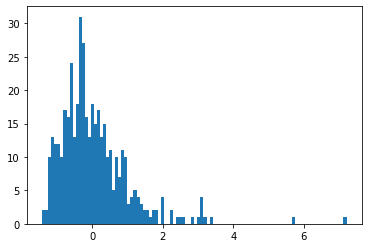

In [197]:
min_v = min(df['target'])
max_v = max(df['target'])
plt.hist(df['target'], bins=100);

In [201]:
import folium
from folium.plugins import HeatMap, FastMarkerCluster

# тепловая карта - салоны, данные с весами, весы - нормированный таргет
# маркеры - railway stations

m = folium.Map(location=[55.750446, 37.617494],
               zoom_start=9,
               tiles='cartodbpositron')
heat_data = [[row['lat'], row['lon'], (row['target'] - min_v) / (max_v - min_v)] for index, row in df.iterrows()]
data = [[row['lat'], row['lon']] for index, row in g.d['stations'].iterrows()]

HeatMap(heat_data, blur=8, radius=14, min_opacity=0.2).add_to(m)
FastMarkerCluster(data).add_to(m)
m

In [203]:
import folium
from folium.plugins import HeatMap, FastMarkerCluster

# тепловая карта - салоны, данные с весами, весы - нормированный таргет
# маркеры - railway stations

m = folium.Map(location=[55.750446, 37.617494],
               zoom_start=9,
               tiles='cartodbpositron')
heat_data = [[row['lat'], row['lon'], (row['target'] - min_v) / (max_v - min_v)] for index, row in df.iterrows()]
data = [[row['lat'], row['lon']] for index, row in g.d['police'].iterrows()]

HeatMap(heat_data, blur=8, radius=14, min_opacity=0.2).add_to(m)
FastMarkerCluster(data).add_to(m)
m